# NLP - Toxic Comments Classifier (Report)
https://toxiccomments.streamlit.app/ 
<br/>
Team Number: 6
<br/>
Team Members: Dina Boshnaq, Iris Loret, Ingrid Hansen

## Introduction
For this assignment we are doing classification of comments to check if they're toxic or not. The dataset used is the Toxic Comment Classification dataset from Kaggle. We will be doing single label classification (toxic or not toxic) instead of multi label classification. We are using a Transformer model from Hugging Face, specifically the DistilBERT base model (uncased). We are doing transfer learning by using the pre-trained tokenizer from the language model (DistilBERT) to initialize a new tokenizer and then build our own model based on it.
We split our dataset then train the model, and finally make predictions on text that we pass to the model.

We are running our code on Kaggle since it has a closer connection to the data source so it uses less memory. Initially we had tried Colab but we were using too much memory so we switched to Kaggle.

## EDA
We start off by downloading the dataset from Kaggle, we will be using the train.csv file to train our data. We load the data file in a dataset on Kaggle. Then we load that file as a pandas dataframe in our code.

We did a simple EDA on the data where we checked the different columns and their datatypes.

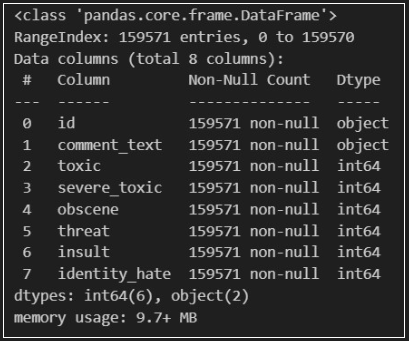

We have a comment_text column with the comments, and 6 different types of toxic comments. But since we're only doing single label classification, we want to have one column as the label to predict. We make one column called is_toxic. That's why for each row, we check if any of the 6 types of toxic comments are set to 1 (1 meaning it is of that type of toxicity, 0 meaning it's not). If at least one of them is set to 1, we set the value in is_toxic to 1. If none of them are valued 1, we set it to 0. Then we drop the 6 columns, keeping only comment_text and is_toxic. We also dropped the id column since there's no use for it.

When checking the value counts of the is_toxic column, the 0 value had 143346 entries while the 1 value had 16225. This causes an imbalance in the data, and it's also too much data since we were still testing it. Therefore, we undersampled and balanced the data out by taking only 2000 samples from each (the 0 entries, and the 1 entries). This will make training the model faster and easier. If we can get this to run then we know it's working and we can increase the number of samples to make a better model.

An issue that was encountered later on when trying to train the model is that it wasn't seeing the is_toxic column as the target label column, so we had to rename it to "label" per the documentation.

Up to this point, the data type of label is integer and it's either 0 or 1. But this isn't enough to identify the labels, especially since we will be assigning the number of labels to 2 when making the model. The model configurations, especially the num_labels parameter, need to match the number of unique labels used during training. id2label and label2id should be correctly configured in the config.json file in the model directory.
If the original labels are numeric (0 and 1), the model might expect a mapping like id2label = {0: '0', 1: '1'} and label2id = {'0': 0, '1': 1}. However, if we use string labels, the mapping would be more intuitive: id2label = {'Not Toxic': 0, 'Toxic': 1} and label2id = {0: 'Not Toxic', 1: 'Toxic'}. We tried both and the second approach worked where we first map 0 to "Not Toxic" and 1 to "Toxic", then encode the labels:

In [ ]:
id2label = {0: "Not Toxic", 1: "Toxic"}
label2id = {"Not Toxic": 0, "Toxic": 1}
df_toxic_balanced["label"] = df_toxic_balanced["label"].apply(lambda x: label2id[x])

This will result in the configuration in the config.json (which will be produced later on when making the model) to be correct later on where we'd have the 2 labels and the correct problem type "single label classification".

The final correct config.json:

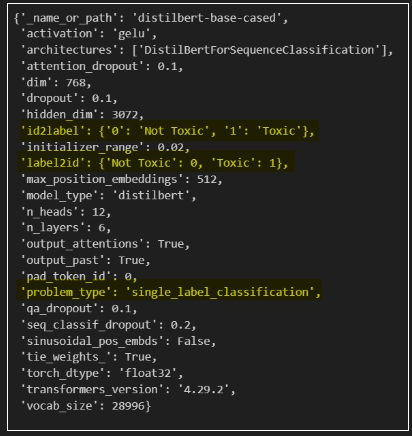

The initial wrong config.json:

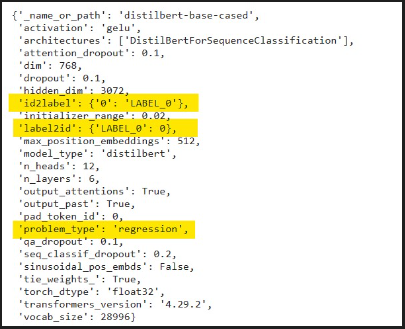


We then make the hugging face dataset from our dataframe in order to apply tokenization on it.

## Tokenizing the data

The pre-trained transformer model we're using is a distilled version of the BERT base model (DistilBERT), specifically the uncased one (case insensitive).
We decided to try this one first since it's smaller and faster than BERT but based on it. It is self-supervised and uses Masked language modeling (MLM) which is in a way good since it can learn in a bidirectional representation of the sentence. It should get the job done, but of course, there are other transformer models out there that are more accurate in classifying comments based on toxicity, however they're bigger and will take a longer time in training. Since we're testing things out first, this model suffices.

A tokenizer is needed in order to convert raw input (sentences) into smaller units such as words, this will help the ML models to understand and process the input. 
We initialize the tokenizer to be used using the AutoTokenizer class from Hugging face transformers library. This class will help us load a pre-trained tokenizer for our model from the pre-trained DistilBERT Uncased model. We set the use_fast parameter to True, this will enable the use of a fast tokenizer.

A function named "preprocess" is created to map the tokenizer to the dataset, specifically to the column "comment_text" which contains the input text to be analyzed. It then applies the tokenizer on each input sentence. The tokenizer is configured with the parameters truncation=True and max_length=128, indicating that it should truncate sequences longer than 128 tokens while ensuring that sequences are not longer than this maximum length. This will ensure that the input sequences have a consistent length which makes the processing by the model more efficient. So in summary, through this function we will prepare the dataset for further processing by transforming the raw text in the "comment_text" column into tokenized sequences suitable for input to natural language processing models.

We apply the preprocess function on our dataset. The mapping function will be applied in batches rather than individually for each sample (batched=True). Then, a DataCollatorWithPadding object (DataCollatorWithPadding is a class in the Hugging Face library) is created to form these batches of the data. We are using the tokenizer we made earlier and a padding strategy 'max_length', which means that the sequences will be padded to the maximum length in the batch. The data collator will create uniform batch sizes, which allow efficient parallel processing in deep learning frameworks, by using Truncation and Padding. These are 2 different ways of achieving uniform batch sizes.
It trunctuates the sequences which exceed the maximum length, and pads the sequences which are less than the maximum length. The maximum length is determined by the maximum length of the input sequences after they have been tokenized by the tokenizer. Truncation involves shortening a sequence by removing tokens from the end. While padding involves adding special tokens (usually zeros) to the end of a sequence to make it equal in length to the maximum sequence length within a batch.

## Creating Train and Test set

We split the tokenized dataset into training and test sets, %70 for training, %30 for testing. Our dataset is now the following:

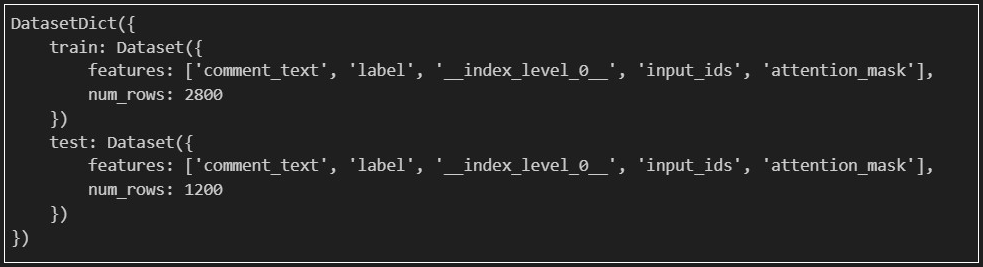

We define the training set and testing set individually so we can pass them to model later. They are called tok_train_dataset and tok_test_dataset.

## Creating an Evaluation Metric

We use the library called "Evaluate" for evaluating our model. It is a library with a wide range of evaluation tools. There are 3 types of evaluations in it, one of them is "Metric" which we will be using. It measures the performance of a model on a given dataset, usually by comparing the model's predictions to some ground truth labels. We will be using an "Accuracy" metric from this type. According to the documentation on the Hugging Face website: Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with: Accuracy = (TP + TN) / (TP + TN + FP + FN) Where: TP: True positive TN: True negative FP: False positive FN: False negative.

Accuracy is a common evaluation metric used to measure the accuracy of a classification model. So it is suitable for our case in binary classification for toxic and non-toxic comments.

We then make a compute_metrics function to be used later in the evaluation of the model. As a parameter, we pass the model's predictions (eval_pred). The function extracts the predicted labels, compares them to the true labels (references), and calculates the accuracy using the loaded accuracy metric. The final accuracy value is then returned. This function encapsulates the logic for computing accuracy during the evaluation phase and will be used in a later step in the model trainer.

## Making the model

And now to make the model. First, we initialize a sequence classification model (we'll give it the name "model") and train it using the Hugging Face Transformers library. The AutoModelForSequenceClassification class is used to load a pre-trained model for our binary sequence classification task. The pre-trained model is the same as the one specified earlier in the tokenization step: distilled version of the BERT base model (DistilBERT). We have 2 labels (binary), 1 for toxic and 0 for not toxic. Additional parameters such as id2label and label2id are provided for label mapping, and output_attentions=True allows the model to output attention weights during training. In NLP, the attention weights are calculated based on the relevance or similarity between the elements and a query or context vector.

We then define the training arguments using a TrainingArguments class, we'll give it the name "training_args". These arguments include:

- output_dir: The directory where the model predictions and checkpoints will be written.
- learning_rate: The learning rate of the optimizer, it is set to 2e-5
- warmup_ratio: The ratio of steps used for the warmup phase of the learning rate scheduler, it is set to 0.1
- lr_scheduler_type: The type of learning rate scheduler to use, it is set to a cosine learning rate scheduler.
- fp16: Precision training, it is set to 16-bit.
- num_train_epochs: The number of epochs to train the model for, it is set to 2 epochs. We could add more but for now only 2 is enough.
- weight_decay: The weight decay to use for the optimizer, it is set to 0.01. 

Let's elaborate more on some points, specifically the cosine learning rate scheduler, fp16, and the weight decay. This type of scheduler will reduce the learning rate from its initial value to a minimum value over the course of the training, and then increase it again to its initial value by the end of the training. As for fp16, it is set to True which means that the model will use 16-bit precision training instead of 32-bit training. This can help reduce the memory requirements of the model and speed up training. As for weight decay, it is a regularization technique that helps prevent overfitting by adding a penalty term to the loss function. The penalty term is proportional to the square of the magnitude of the weights, which encourages the model to learn smaller weights. This can help prevent the model from fitting the training data too closely and improve its generalization performance on new data. In our case, the penalty term added to the loss function will be proportional to the square of the magnitude of the weights multiplied by 0.01.

And now to actually train the model, we will use the Trainer class. This class is part of the PyTorch Lightning library, which is a lightweight wrapper around PyTorch that provides a high-level interface for training deep learning models. We make an instance of this class with the following arguments (All of the arguments passed were defined in previous steps):

- model: The machine learning model to be trained. This is the sequence classification model (model).
- args: The training arguments (training_args).
- train_dataset: The dataset to be used for training the model (tok_train_dataset).
- eval_dataset: The dataset to be used for evaluating the model (tok_test_dataset).
- tokenizer: The tokenizer to be used for tokenizing the input data (tokenizer).
- data_collator: The data collator to be used for collating the input data (data_collator).
- compute_metrics: The function to be used for computing the evaluation metrics (compute_metrics).

We finally start training the model using the "train" method of the Trainer object. It iterates through epochs, updating the model's weights based on the training dataset and evaluating performance on the validation set.

The following is the output when we train the model:

In [ ]:
# Training the model on our data with our specific training arguements
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_train_dataset,
    eval_dataset=tok_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

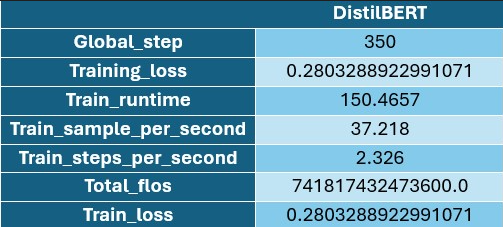

## Saving the model

We save the traind model along with other training rlated information through the save_model method of the Trainer object. This will be the model we'll use in Streamlit later. The model's name is "comments_model".

We had also tried saving the model into a pickle file but this only saved the raw model object as is, without any additional information related to training so we didn't use it in the streamlit app.

## Testing the model

And now to test our model!

The AutoTokenizer and AutoModelForSequenceClassification classes from the Hugging Face Transformers library are used to load the tokenizer and model, respectively. After loading the tokenizer and model, a text classification pipeline is created using the loaded model and tokenizer. The TextClassificationPipeline class from the Transformers library is used to create this pipeline.

Finally, the pipeline is used to make predictions on two sample texts, “You are beautiful” (which is expected to be a "not toxic" comment) and “You are ugly” (which is expected to be a "toxic" comment).

In [62]:
# Load the pre-trained tokenizer and model
model_path = "/kaggle/working/comments_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
 
# Create a text classification pipeline using the loaded model and tokenizer
pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)

# Make predictions on sample texts and print the results
print(pipeline("You are beautiful"))
print(pipeline("You are ugly"))

[{'label': 'Not Toxic', 'score': 0.7726908326148987}]
[{'label': 'Toxic', 'score': 0.9823653101921082}]


As expected, the model classified the first as not toxic (with an accuracy score of 77%) and the second as toxic (with an accuracy score of 98%).

## Extra: Include a Streamlit deployment

Streamlit app URL: https://toxiccomments.streamlit.app/

We made an app where we showcase the EDA we performed and provide a text box for users to enter a comment. Our model then makes a prediction on it and classifies whether it's toxic or not.

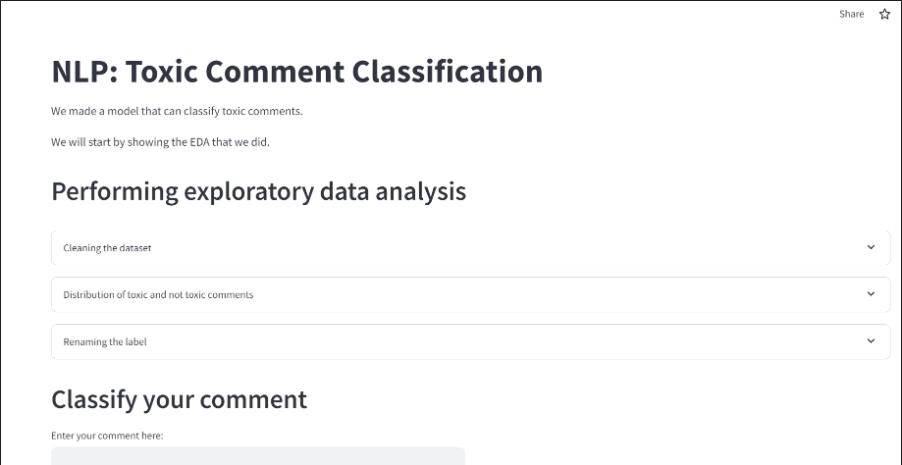

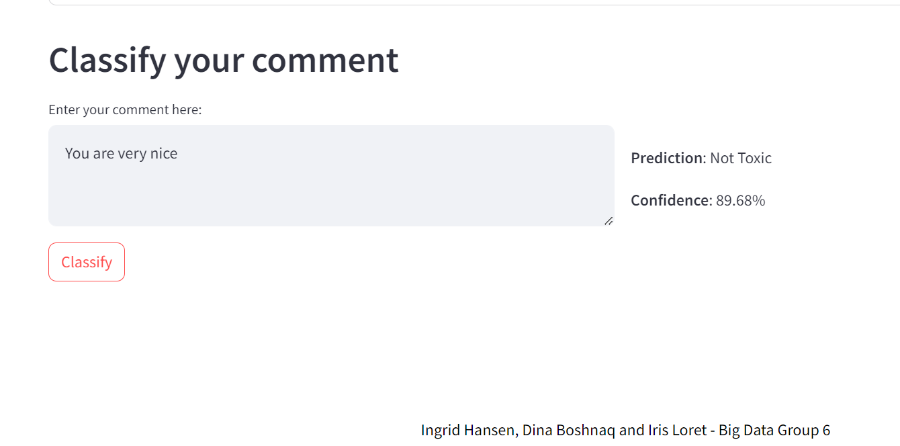

## Extra: Trying a different Transformer model (BERT)

We decided to try out BERT instead of DistilBERT to compare their results. DistilBERT is based on BERT but they have some differences.

BERT is a larger and more complex model than DistilBERT. It has been pre-trained on a larger corpus of data and has more parameters than DistilBERT. As a result, BERT is generally more accurate than DistilBERT on many natural language processing tasks, including text classification.

On the other hand, DistilBERT is a smaller and faster version of BERT that has been pre-trained on a smaller corpus of data. It has fewer parameters than BERT and is faster to train and use.

Considering that BERT is larger, it might do better than DistilBERT if we give both more data (more than 2000 samples per label). But to compare them right now, we'll stick to our current sample size.

All the code for EDA, tokenizer, creating train/test dataset, creating evaluation metric is the same. This provides better ground for fair comparison. We only included the code that gives different outputs like the model training time, training loss, accuracy scores and such.

We change the pretrained model. This will thus change the tokenizer we're based on, as well as the model we train based on.

In [ ]:
# Testing our code out with BERT Transformer model from Hugging Face
pretrained_model = 'bert-base-uncased'

The epochs remain 2.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_train_dataset,
    eval_dataset=tok_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

We can already see the difference when training the model.
The following differences are noticed:

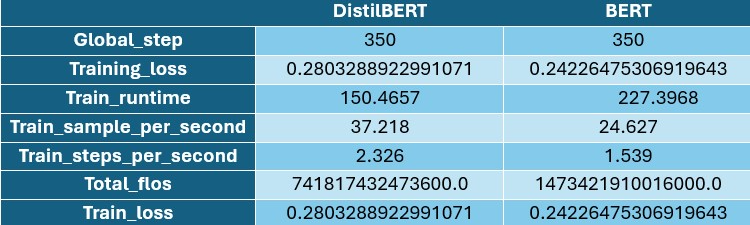

BERT took a longer time but it had less training loss and trained less samples per second.

In [ ]:
# Save the BERT model
trainer.save_model("comments_model_bert")

And now if we load the saved model and apply predictions on the same text pieces that we gave to DistilBERT, we assume they'll have a higher accuracy score.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
 
model_path = "/kaggle/working/comments_model_bert"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
 
pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)
print(pipeline("You are beautiful"))
print(pipeline("You are ugly"))

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


[{'label': 'Not Toxic', 'score': 0.9476667046546936}]
[{'label': 'Toxic', 'score': 0.9899339079856873}]


As expected, it gave correct and more accurate predictions compared to DistilBERt, which had the following predictions:

[{'label': 'Not Toxic', 'score': 0.7726908326148987}]
<br/>
[{'label': 'Toxic', 'score': 0.9823653101921082}]

We decided to test this model on different texts that wouldn't be so obvious:

In [ ]:
# Testing with other comments
print(pipeline("you're so so"))
print(pipeline("I wish you were dead"))
print(pipeline("you're gorgeous"))

[{'label': 'Toxic', 'score': 0.5880172252655029}]
[{'label': 'Toxic', 'score': 0.748916506767273}]
[{'label': 'Not Toxic', 'score': 0.7389889359474182}]


To our surprise, it gave correct an accurate predictions. Specifically the first, we were surprised it predicted that one correct. Saying "you're so so" to someone is on the very edge of toxic and not toxic, but most people would consider it somewhat not nice, thus toxic. So, before we ran the code, we were wondering whether it would tell that it's, well, so so. And it did! It gave it an accuracy score of 58% toxic, so it indeed thought of it the same way as in middle but slightly toxic.

If we check the config.json file we see that the base model is indeed bert-base-uncased.

In [ ]:
# For extra insight, we look at the json file
import json

config_path = "/kaggle/working/comments_model_bert/config.json"

with open(config_path, 'r') as config_file:
    config = json.load(config_file)

config


{'_name_or_path': 'bert-base-uncased',
 'architectures': ['BertForSequenceClassification'],
 'attention_probs_dropout_prob': 0.1,
 'classifier_dropout': None,
 'gradient_checkpointing': False,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'id2label': {'0': 'Not Toxic', '1': 'Toxic'},
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'label2id': {'Not Toxic': 0, 'Toxic': 1},
 'layer_norm_eps': 1e-12,
 'max_position_embeddings': 512,
 'model_type': 'bert',
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'output_attentions': True,
 'pad_token_id': 0,
 'position_embedding_type': 'absolute',
 'problem_type': 'single_label_classification',
 'torch_dtype': 'float32',
 'transformers_version': '4.29.2',
 'type_vocab_size': 2,
 'use_cache': True,
 'vocab_size': 30522}

## NLP Classification Toxic-Comments Code

The full code can be found in toxic-comments-final.ipynb

Streamlit code can be found in NLPStreamlit/streamlit.py

## Conclusion

To conclude, even though we encountered some problems here and there, overall it was doable. We are proud of our toxic-comment classification model and it's accuracy scores, as well as the streamlit app.